In [6]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

import sys
sys.path.append('../.')
import datasets

In [7]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [8]:
sample_size = 200
feature_dimension = 50
used_feature = feature_dimension
noise_level = 0
bias = 1
y_dimension = 5
test_size = 0.5
RAND_ST = None

X, y = datasets.linear_regression_with_gaussian(sample_size=sample_size, feautre_size=feature_dimension, used_feature=used_feature, noise_level=noise_level, bias=bias, y_dimension=y_dimension, random_state=RAND_ST)

X = np.column_stack((np.ones(sample_size), X)) + np.random.normal(0, 0.1, (sample_size, feature_dimension+1))

In [9]:
class linear_regression_dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).to(torch.float32).to(device)
        self.y = torch.from_numpy(y).to(torch.float32).to(device)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        return x, y

In [10]:
class Linear_regression(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(feature_dimension+1, y_dimension, bias=False)
        )
        
    def forward(self, x):
        return self.linear(x)

In [11]:
lr = 0.01
max_epoch = 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RAND_ST, shuffle=True)
train_dataset = linear_regression_dataset(X_train, y_train)
test_dataset = linear_regression_dataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

In [12]:
def train_model():
    # loss function type
    loss_fn = nn.MSELoss()
    # model
    lr_model = Linear_regression().to(device)
    # optimizer type
    optimizer = torch.optim.SGD(lr_model.parameters(), lr=lr)
    
    epochs = max_epoch
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            loss_fn(lr_model(x), y).backward()
            optimizer.step()
    
    total_train_loss = 0
    total_test_loss = 0
    with torch.no_grad():
        lr_model.eval()
        
        for x, y in train_loader:
            total_test_loss += loss_fn(lr_model(x), y)
        
        for x, y in test_loader:
            total_test_loss += loss_fn(lr_model(x), y)
    
    train_loss = total_train_loss / len(train_loader)
    test_loss = total_test_loss / len(test_loader)

    return train_loss, test_loss

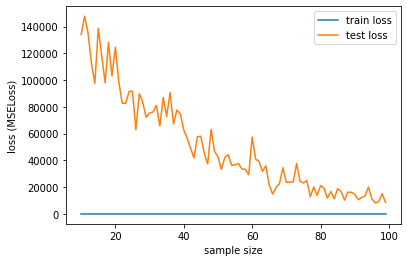

In [13]:
train_losses = []
test_losses = []

samples = [sample for sample in range(10, int(sample_size/2), 1)]

for sample in samples:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RAND_ST, shuffle=True)
    train_dataset = linear_regression_dataset(X_train[:sample], y_train[:sample])
    test_dataset = linear_regression_dataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=1)
    test_loader = DataLoader(test_dataset, batch_size=1)
    
    train_loss, test_loss = train_model()
    train_losses.append(float(train_loss))
    test_losses.append(float(test_loss))
    
    # print(float(train_loss))
    # print(float(test_loss))
    # print(sample)
    # print()

plt.xlabel("sample size")
plt.ylabel("loss (MSELoss)")
plt.plot(samples, train_losses, label = "train loss")
plt.plot(samples, test_losses, label = "test loss")
plt.legend()
plt.show()
